In [4]:
from io import BytesIO
from PIL import Image
import datasets
import joblib
from transformers import CLIPProcessor, CLIPModel
from sklearn.linear_model import LogisticRegression
import torch
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
# Load model and pre-processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [8]:
def get_embedding_and_zs(sample):
    # import pdb; pdb.set_trace()
    # Gender prediction
    inputs = processor(text=["the face of a man", "the face of a woman"], images=sample["image"], return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    gender_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    
    sample["zs_gender_clip"] = [int(gp) for gp in gender_pred]
    # Store embeddings
    sample["embeddings"] = outputs.image_embeds
    
    # Race prediction
    # # In the label, if the race is east or southeast asian, set 0 - merge the classes (for deepface to adapt)
    for idx, race in enumerate(sample["race"]):
        if race in {0,6}:
            sample["race"][idx] = 0
    inputs = processor(text=["Asian", "Indian", "Black", "White", "Middle Eastern", "Latino Hispanic"], images=sample["image"], return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    race_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    
    sample["zs_race_clip"] = [int(rp) for rp in race_pred]
    return sample
    

In [9]:
# Load training data
train_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split='train', verification_mode="no_checks")
# train_ds = train_ds.shuffle(seed=42).select([i for i in range(1_000)]) # Take only first 20_000 images
train_ds = train_ds.shuffle(seed=42)
train_ds = train_ds.map(get_embedding_and_zs, batched = True, batch_size=16)
# train_ds = train_ds.map(get_deepface_preds)

Map:   0%|          | 0/86744 [00:00<?, ? examples/s]

C:\Users\Debadyuti\.conda\envs\dissertation-env\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


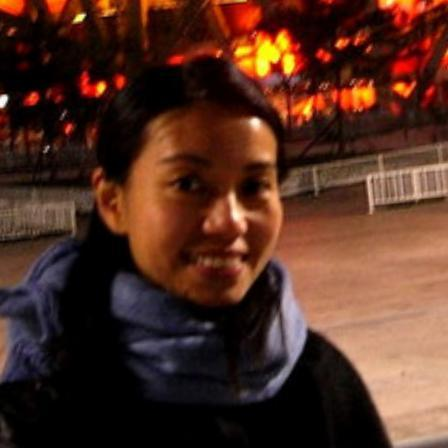

In [10]:
train_ds[0]["image"]

In [11]:
# train_ds[0]

In [12]:
# Load validation data and test on this
valid_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split="validation", verification_mode="no_checks")
# valid_ds = valid_ds.shuffle(seed=42).select([i for i in range(6_000)]) # Take only first 6_000 images
valid_ds = valid_ds.shuffle(seed=42) 
valid_ds = valid_ds.map(get_embedding_and_zs, batched = True, batch_size=16)
# valid_ds = valid_ds.map(get_deepface_preds)

Map:   0%|          | 0/10954 [00:00<?, ? examples/s]

In [13]:
# # Load test data as second 50% of val split
# test_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split="validation[50%:]", verification_mode="no_checks")
# test_ds = test_ds.shuffle(seed=42).select([i for i in range(6_000)]) # Take only first 6_000 images
# test_ds = test_ds.map(get_embedding_and_zs, batched = True, batch_size=16)

In [14]:
train_ds

Dataset({
    features: ['image', 'age', 'gender', 'race', 'service_test', 'zs_gender_clip', 'embeddings', 'zs_race_clip'],
    num_rows: 86744
})

In [15]:
# import tensorflow as tf
# tf.__version__

In [16]:
X_train = np.array(train_ds["embeddings"])
y_train_gender = np.array(train_ds["gender"])
y_train_race = np.array(train_ds["race"])

In [17]:
lr_clf_gender = LogisticRegression(random_state=42)
lr_clf_gender.fit(X_train, y_train_gender)

LogisticRegression(random_state=42)

In [18]:
lr_clf_race = LogisticRegression(random_state=42, max_iter=200)
lr_clf_race.fit(X_train, y_train_race)

LogisticRegression(max_iter=200, random_state=42)

In [19]:
X_val = np.array(valid_ds["embeddings"])
y_val_gender = np.array(valid_ds["gender"])
y_val_race = np.array(valid_ds["race"])

In [20]:
train_acc = lr_clf_gender.score(X_train, y_train_gender)
val_acc = lr_clf_gender.score(X_val, y_val_gender)
print(f"Training accuracy for gender: {train_acc*100:.4f}%")
print(f"Validation accuracy for gender: {val_acc*100:.4f}%")

Training accuracy for gender: 96.0424%
Validation accuracy for gender: 96.1567%


In [21]:
# y_preds = lr_clf_gender.predict(X_train)
# from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_train_gender, y_preds, average='micro')

In [22]:
# train_acc = lr_clf_race.score(X_train, y_train_race)
# val_acc = lr_clf_race.score(X_val, y_val_race)
# print(f"Training accuracy for race: {train_acc*100:.4f}%")
# print(f"Validation accuracy for race: {val_acc*100:.4f}%")

In [23]:
y_preds = lr_clf_race.predict(X_train)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_train_race, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_train_race, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_train_race, y_preds, average='micro')
train_acc = lr_clf_race.score(X_train, y_train_race)
print(f"Training set metrics - Race (LR + CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Race (LR + CLIP) 
Accuracy: 0.7883 Precision: 0.7860, Recall: 0.7883, F-Score(Weighted): 0.7869, F-Score(Micro): 0.7883, F-Score(Macro): 0.7672


In [24]:
y_preds = lr_clf_race.predict(X_val)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_val_race, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_val_race, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_val_race, y_preds, average='micro')
val_acc = lr_clf_race.score(X_val, y_val_race)
print(f"Validation set metrics - Race (LR + CLIP)\n" + "="*40)
print(f"Accuracy: {val_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Race (LR + CLIP)
Accuracy: 0.7886 Precision: 0.7867, Recall: 0.7886, F-Score(Weighted): 0.7874, F-Score(Micro): 0.7886, F-Score(Macro): 0.7663


In [25]:
y_preds = lr_clf_gender.predict(X_train)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_train_gender, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_train_gender, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_train_gender, y_preds, average='micro')
train_acc = lr_clf_gender.score(X_train, y_train_gender)
print(f"Training set metrics - Gender (LR + CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Gender (LR + CLIP) 
Accuracy: 0.9604 Precision: 0.9604, Recall: 0.9604, F-Score(Weighted): 0.9604, F-Score(Micro): 0.9604, F-Score(Macro): 0.9603


In [26]:
y_preds = lr_clf_gender.predict(X_val)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_val_gender, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_val_gender, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_val_gender, y_preds, average='micro')
val_acc = lr_clf_gender.score(X_val, y_val_gender)
print(f"Validation set metrics - Gender (LR + CLIP)\n" + "="*40)
print(f"Accuracy: {val_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Gender (LR + CLIP)
Accuracy: 0.9616 Precision: 0.9616, Recall: 0.9616, F-Score(Weighted): 0.9616, F-Score(Micro): 0.9616, F-Score(Macro): 0.9615


In [27]:
# # Zero shot metrics
# train_acc = np.sum(np.array(train_ds["zs_gender_clip"]) == np.array(train_ds["gender"])) / len(train_ds)
# val_acc = np.sum(np.array(valid_ds["zs_gender_clip"]) == np.array(valid_ds["gender"])) / len(valid_ds)
# print(f"Training accuracy for gender: {train_acc*100:.4f}%")
# print(f"Validation accuracy for gender: {val_acc*100:.4f}%")

In [28]:
y_preds = train_ds["zs_gender_clip"]
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_train_gender, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_train_gender, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_train_gender, y_preds, average='micro')
train_acc = np.sum(y_preds == y_train_gender) / len(y_preds)
print(f"Training set metrics - Gender (ZS CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Gender (ZS CLIP) 
Accuracy: 0.9491 Precision: 0.9498, Recall: 0.9491, F-Score(Weighted): 0.9491, F-Score(Micro): 0.9491, F-Score(Macro): 0.9490


In [29]:
y_preds = valid_ds["zs_gender_clip"]
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_val_gender, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_val_gender, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_val_gender, y_preds, average='micro')
valid_acc = np.sum(y_preds == y_val_gender) / len(y_preds)
print(f"Validation set metrics - Gender (ZS CLIP) \n" + "="*40)
print(f"Accuracy: {valid_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Gender (ZS CLIP) 
Accuracy: 0.9506 Precision: 0.9512, Recall: 0.9506, F-Score(Weighted): 0.9506, F-Score(Micro): 0.9506, F-Score(Macro): 0.9505


In [30]:
y_preds = train_ds["zs_race_clip"]
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_train_race, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_train_race, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_train_race, y_preds, average='micro')
train_acc = np.sum(y_preds == y_train_race) / len(y_preds)
print(f"Training set metrics - Race (ZS CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Race (ZS CLIP) 
Accuracy: 0.5018 Precision: 0.4953, Recall: 0.5018, F-Score(Weighted): 0.4347, F-Score(Micro): 0.5018, F-Score(Macro): 0.3947


In [31]:
y_preds = valid_ds["zs_race_clip"]
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_val_race, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_val_race, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_val_race, y_preds, average='micro')
valid_acc = np.sum(y_preds == y_val_race) / len(y_preds)
print(f"Validation set metrics - Race (ZS CLIP) \n" + "="*40)
print(f"Accuracy: {valid_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Race (ZS CLIP) 
Accuracy: 0.5083 Precision: 0.5038, Recall: 0.5083, F-Score(Weighted): 0.4448, F-Score(Micro): 0.5083, F-Score(Macro): 0.4043


In [32]:
# # Zero shot metrics
# train_acc = np.sum(np.array(train_ds["zs_race_clip"]) == np.array(train_ds["race"])) / len(train_ds)
# val_acc = np.sum(np.array(valid_ds["zs_race_clip"]) == np.array(valid_ds["race"])) / len(valid_ds)
# print(f"Training accuracy for race: {train_acc*100:.4f}%")
# print(f"Validation accuracy for race: {val_acc*100:.4f}%")

In [41]:
# Save Gender model
joblib.dump(lr_clf_gender, '../models/lr_clf_gender.joblib')
print("Model saved successfully!")
# To load the model from the file later
clf_gender_loaded = joblib.load('../models/lr_clf_gender.joblib')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


In [39]:
# Save Race model
joblib.dump(lr_clf_race, '../models/lr_clf_race.joblib')
print("Model saved successfully!")
# To load the model from the file later
clf_race_loaded = joblib.load('../models/lr_clf_race.joblib')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!
